<a href="https://colab.research.google.com/github/Alindaive/Aalzheimer_detection/blob/main/Alzheimer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Environment check
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix 
import itertools 
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import cv2
import glob

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
g = !ls gdrive/MyDrive/archive.zip 

In [ ]:
!unzip /content/gdrive/MyDrive/archive.zip -d /content/Dataset/

In [196]:
data = "../content/Dataset/AugmentedAlzheimerDataset"

In [197]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [198]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("../content/Dataset/AugmentedAlzheimerDataset").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [199]:
image_df

,Filepath,Label
0,../content/Dataset/AugmentedAlzheimerDataset/M...,MildDemented
1,../content/Dataset/AugmentedAlzheimerDataset/M...,MildDemented
2,../content/Dataset/AugmentedAlzheimerDataset/M...,MildDemented
3,../content/Dataset/AugmentedAlzheimerDataset/M...,MildDemented
4,../content/Dataset/AugmentedAlzheimerDataset/M...,MildDemented
...,...,...
33979,../content/Dataset/AugmentedAlzheimerDataset/N...,NonDemented
33980,../content/Dataset/AugmentedAlzheimerDataset/N...,NonDemented
33981,../content/Dataset/AugmentedAlzheimerDataset/N...,NonDemented
33982,../content/Dataset/AugmentedAlzheimerDataset/N...,NonDemented


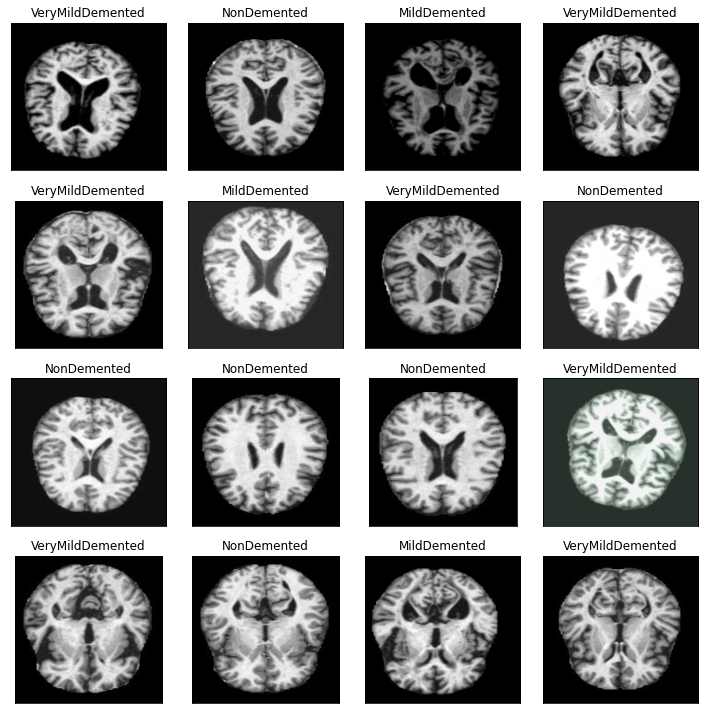

In [200]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [194]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

In [201]:
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [10]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

In [35]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
850/850 [==============================] - 1209s 1s/step - loss: 0.0489 - accuracy: 0.9827 - val_loss: 0.3025 - val_accuracy: 0.9225
Epoch 2/10
850/850 [==============================] - 1232s 1s/step - loss: 0.0461 - accuracy: 0.9845 - val_loss: 0.3270 - val_accuracy: 0.9180
Epoch 3/10
850/850 [==============================] - 1230s 1s/step - loss: 0.0388 - accuracy: 0.9870 - val_loss: 0.3299 - val_accuracy: 0.9194
Epoch 4/10
850/850 [==============================] - 1235s 1s/step - loss: 0.0395 - accuracy: 0.9865 - val_loss: 0.3041 - val_accuracy: 0.9210
Epoch 5/10
850/850 [==============================] - 1219s 1s/step - loss: 0.0366 - accuracy: 0.9878 - val_loss: 0.3486 - val_accuracy: 0.9200
Epoch 6/10
850/850 [==============================] - 1158s 1s/step - loss: 0.0359 - accuracy: 0.9881 - val_loss: 0.3568 - val_accuracy: 0.9254
Epoch 7/10
850/850 [==============================] - 1161s 1s/step - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.3633 - val_accuracy:

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

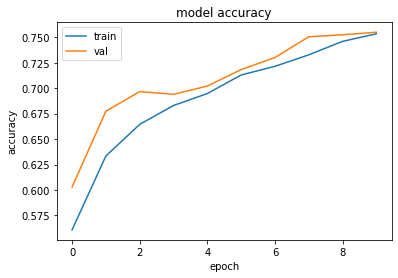

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

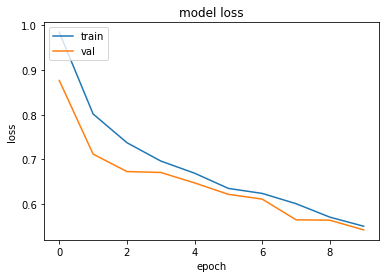

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# saving the model +++
model.save('MyModel_h5',save_format='h5')

In [13]:
# loaing the model +++
model = tf.keras.models.load_model('MyModel_h5')

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [8]:
Y_test_all=[]

In [15]:
Y_pred_all = []

In [ ]:
import glob

#แก้
path = glob.glob("/content/Dataset/AugmentedAlzheimerDataset/VeryMildDemented/*.jpg")
#แก้
predY_3 = []
for img in path:
    img = cv2.imread(img)
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3])
    classes = model.predict(img)
    #แก้
    predY_3.append(classes)
    Y_pred_all.append(classes)
    #แก้
    Y_test_all.append(3)


In [ ]:
cm = confusion_matrix(Y_test_all_tran, con_pred_all)

In [90]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[8829    8   31   92]
 [  33 6422    1    8]
 [ 256    6 9041  297]
 [ 376   12  200 8372]]


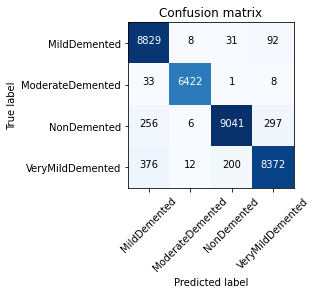

In [91]:
cm_plot_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')

In [120]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

In [183]:
#%% ROC-AUC Curve

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Learn to predict each class against the other


n_classes = 4 # number of class




# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_all_tran_roc[:, i], con_pred_all_roc[:, i] )
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_all_tran_roc.ravel(), con_pred_all_roc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

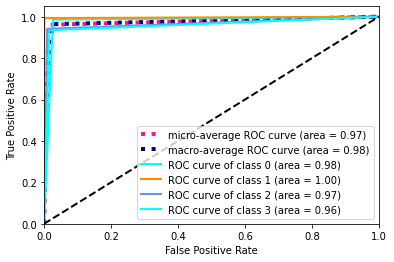

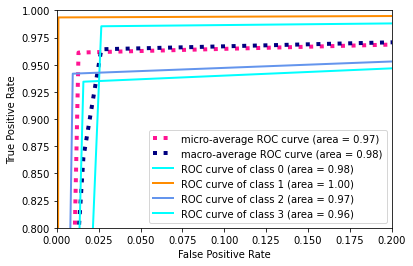

In [186]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Y_test_all_tran_roc[:, i], con_pred_all_roc[:, i] )
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_all_tran_roc.ravel(), con_pred_all_roc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [188]:
from sklearn.metrics import classification_report

In [193]:
print(classification_report(con_pred_all,Y_test_all_tran))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      9494
           1       0.99      1.00      0.99      6448
           2       0.94      0.97      0.96      9273
           3       0.93      0.95      0.94      8769

    accuracy                           0.96     33984
   macro avg       0.96      0.96      0.96     33984
weighted avg       0.96      0.96      0.96     33984



In [ ]:
#ทดสอบ

In [ ]:
img = cv2.imread("../content/2.jpg")
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])

classes1 = model.predict(img)

In [75]:
classes1[0]

array([0., 0., 1., 0.], dtype=float32)